In [1]:
import pandas as pd
import numpy as np
import theano
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import NeuralNet, TrainSplit
import warnings
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.updates import nesterov_momentum, sgd
from lasagne.objectives import squared_error, categorical_crossentropy, binary_crossentropy
from lasagne.nonlinearities import sigmoid, rectify, softmax, linear, tanh, rectify, leaky_rectify, very_leaky_rectify
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.utils.validation import NonBLASDotWarning
import theano
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_data
from gini import normalized_gini
from numpy import log
from sklearn.metrics import confusion_matrix
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.updates import nesterov_momentum, sgd
from lasagne.objectives import squared_error, categorical_crossentropy, binary_crossentropy
from lasagne.nonlinearities import sigmoid, rectify, softmax, linear, tanh
from nolearn.lasagne import NeuralNet, TrainSplit

warnings.simplefilter('always', NonBLASDotWarning)
%matplotlib inline

dat_x_orig, dat_y_orig, lb_x_orig, lb_ind = get_data()

Using gpu device 0: GeForce GT 750M


Load data

In [2]:
dat_x_orig, dat_y_orig, lb_x_orig, lb_ind = get_data()

Relabel and scale

In [3]:
def labels(n):
    if n <= 2:
        return 0
    else:
        return 1
    
#     elif n == 2:
#         return 1
#     elif n == 3:
#         return 2
#     elif n <= 5:
#         return 3
#     elif n <= 9:
#         return 4
#     elif n <= 16:
#         return 5
#     elif n <= 40:
#         return 6
#     else:
#         return 7

nplabels = np.vectorize(labels)

scaler = preprocessing.StandardScaler().fit(dat_x_orig)
dat_x = scaler.transform(dat_x_orig)
lb_x = scaler.transform(lb_x_orig)
dat_y = nplabels(dat_y_orig) #** 0.75

In [4]:
dat_y.shape

(50999,)

In [5]:
#pd.Series(dat_y).value_counts()

#numpy.random.choice(a, size=None, replace=True, p=None)¶
#0    18981
#1     6145 *3
#2     2025 *9
#3    11918 *1.5
#4     7213 *2.5
#5     3848 * 4.5
#6      854 *20
#7       15 *1000

#dat_x_1 = dat_x[dat_y == 1]
#dat_y_1 = dat_y[dat_y == 1]
#pick_1 = np.random.choice(range(dat_x_1.shape[0]), 13000)
#dat_x = np.vstack( (dat_x, dat_x_1[pick_1]))
#dat_y = np.hstack( (dat_y, dat_y_1[pick_1]))

def addmore(label, amt, orig_x, orig_y):    
    dat_x_2 = orig_x[orig_y == label]
    dat_y_2 = orig_y[orig_y == label]
    pick_2 = np.random.choice(range(dat_x_2.shape[0]), amt)
    new_dat_x = np.vstack( (orig_x, dat_x_2[pick_2]))
    new_dat_y = np.hstack( (orig_y, dat_y_2[pick_2]))
    return new_dat_x, new_dat_y

# dat_x, dat_y = addmore(1, 17000, dat_x, dat_y)
# dat_x, dat_y = addmore(2, 17000, dat_x, dat_y)
# dat_x, dat_y = addmore(3, 7000, dat_x, dat_y)
# dat_x, dat_y = addmore(4, 10000, dat_x, dat_y)
# dat_x, dat_y = addmore(5, 15000, dat_x, dat_y)
# dat_x, dat_y = addmore(6, 17000, dat_x, dat_y)
# dat_x, dat_y = addmore(7, 17000, dat_x, dat_y)
dat_y_orig = dat_y

Split dataset into train/test

In [6]:
train_index, test_index = train_test_split(range(dat_x.shape[0]), test_size=0.15, random_state=103)

cv_x = dat_x[test_index, :]
cv_y = dat_y[test_index]
cv_y_true = dat_y_orig[test_index]
train_x = dat_x[train_index, :]
train_y = dat_y[train_index]

pd.Series(train_y).value_counts()

# train_x, train_y = addmore(1, 80, train_x, train_y) #11K
# train_x, train_y = addmore(2, 100, train_x, train_y) #14K
# train_x, train_y = addmore(3, 20, train_x, train_y) #6K
# train_x, train_y = addmore(4, 30, train_x, train_y) #10K
# train_x, train_y = addmore(5, 100, train_x, train_y) #13K
# train_x, train_y = addmore(6, 250, train_x, train_y) #15K
# train_x, train_y = addmore(7, 300, train_x, train_y) #15000

# pd.Series(train_y).value_counts()

# 0    16118
# 1     5232
# 2     1728
# 3    10126
# 4     6157
# 5     3259
# 6      717
# 7       12



1    21999
0    21350
dtype: int64

Prepare for Theano

In [7]:
train_x = np.asarray(train_x, dtype = theano.config.floatX)
train_y = np.asarray(train_y, dtype = 'int32')
cv_x = np.asarray(cv_x, dtype = theano.config.floatX)
cv_y = np.asarray(cv_y, dtype = 'int32')

In [8]:

def on_epoch_finished(obj, train_history):
    if (len(train_history) > 5):
        inLastEight = any([h['valid_loss_best'] for h in  train_history[-4:-1]] +
                          [train_history[-1]['valid_loss'] < train_history[-2]['valid_loss'],
                           train_history[-1]['valid_loss'] < train_history[-3]['valid_loss'],
                           ])
        if not inLastEight:
            print("Stopping early")
            raise StopIteration

def NeuralNetConstructor(num_features, max_epochs=5, update_learning_rate=0.2, verbose=1):
    layers0 = [
        ('input', InputLayer),
#         ('dropout0', DropoutLayer),
        ('hidden1', DenseLayer),
#         ('hidden2', DenseLayer),
        ('output', DenseLayer)]

    #LSTMLayer
    net0 = NeuralNet(
        layers=layers0,

        input_shape=(None, num_features),
        input_nonlinearity=None,

#         dropout0_p=0.2,

        hidden1_num_units=10, #75, #20,
        hidden1_nonlinearity=sigmoid,

#         hidden2_num_units=10, #70, #24,
#         hidden2_nonlinearity=rectify,

        output_num_units=2,
        output_nonlinearity=softmax,

        on_epoch_finished=[on_epoch_finished],

        objective_loss_function=categorical_crossentropy, #binary_crossentropy, #squared_error, categorical_crossentropy
        update=nesterov_momentum,
        update_learning_rate=update_learning_rate, #0.02,
        update_momentum=0.9,
        train_split=TrainSplit(eval_size=0.2),
        verbose=verbose,
        regression=False,
        max_epochs=max_epochs)

    return net0

network = NeuralNetConstructor(111, max_epochs=200, update_learning_rate=0.01, verbose=1)
network.fit(train_x, train_y)
cv_preds = network.predict(cv_x)

pd.Series(cv_y).value_counts()

# Neural Network with 1142 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       111
  1  hidden1      10
  2  output        2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.69256       0.67933      1.01948      0.56271  0.26s
      2       0.67824       0.67461      1.00538      0.57768  0.25s
      3       0.67415       0.67234      1.00269      0.58112  0.30s
      4       0.67187       0.67127      1.00088      0.58425  0.32s
      5       0.67059       0.67083      0.99965      0.58384  0.25s
      6       0.66987       0.67067      0.99881      0.58533  0.25s
      7       0.66942       0.67062      0.99822      0.58518  0.32s
      8       0.66912       0.67061      0.99778      0.58530  0.26s
      9       0.66890       0.67061      0.99744      0.58514  0.25s
     10       0.66871       0.67061      0.99716      0.58537  0.2

1    3874
0    3776
dtype: int64

[[2091 1685]
 [1464 2410]]


/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


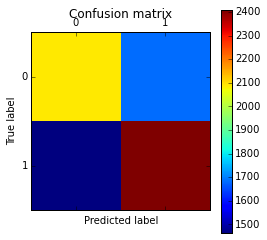

0.179644500932


In [9]:
cm = confusion_matrix(cv_y, cv_preds)
print(cm)

#pd.DataFrame(cv_preds).hist()

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(normalized_gini(cv_y_true, cv_preds))

## PREV

[[2091 1685]
 [1464 2410]]


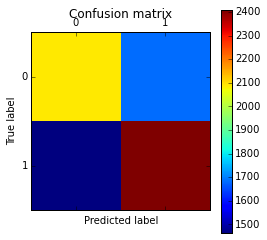

0.179644500932


In [10]:

#cm = confusion_matrix(cv_y, cv_preds)
#prev_cm = cm
print(prev_cm)

#pd.DataFrame(cv_preds).hist()

plt.matshow(prev_cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(normalized_gini(cv_y_true, cv_preds))

In [11]:
dat_y_orig

array([0, 1, 0, ..., 1, 1, 1])